## Palantir Tutorial
https://nbviewer.jupyter.org/github/dpeerlab/Palantir/blob/master/notebooks/Palantir_sample_notebook.ipynb

Adapted code based on tutorial complementing Setty et al Nature Biotech 2019 (tutorial link above)

In [1]:
# Script for multiple runs of wanderlust 
%load_ext autoreload
%autoreload 2

In [2]:
import palantir

# Plotting and miscellaneous imports
import os
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

/Users/mcfefa/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Load Data

In [73]:
# Load sample data
#     data supplied as part of the Setty et al Palantir tutorial
palantir_dir = os.path.expanduser('/Users/mcfefa/Palantir')
counts = palantir.io.from_csv('/Users/mcfefa/Dropbox/Meg-Moffitt-Laptop/Padron/scRNAseq/cell-fate-analysis/marrow_sample_scseq_counts.csv')

### Data pre-cleaned up by Setty et al.

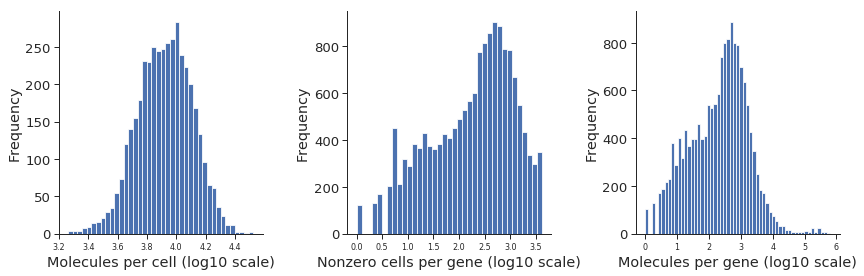

In [74]:
fig, ax = palantir.plot.plot_molecules_per_cell_and_gene(counts)

### Normalization 

In [75]:
norm_df = palantir.preprocess.normalize_counts(counts)

In [76]:
norm_df = palantir.preprocess.log_transform(norm_df)

### Data preprocessing

using pre-calculated tSNSE projections from Setty et al. tutorial

In [77]:
import pandas as pd
# tsne embeddings supplied as part of the Setty et al Palantir tutorial
tsne = pd.read_pickle('/Users/mcfefa/Dropbox/Meg-Moffitt-Laptop/Padron/scRNAseq/cell-fate-analysis/sample_tsne.p')

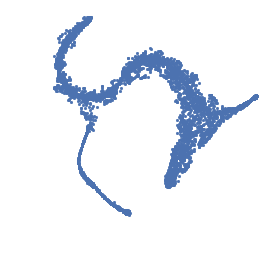

In [78]:
# visualizing the tsne embeddings of the data
fig, ax = palantir.plot.plot_tsne(tsne)

#### MAGIC imputation

In [79]:
import numpy as np
import magic
import scprep

In [91]:
# perform imputation on single cell data using MAGIC
magic_op = magic.MAGIC() 
imp_df = magic_op.fit_transform(norm_df)

Calculating MAGIC...
  Running MAGIC on 4142 cells and 16106 genes.
  Calculating graph and diffusion operator...
Calculating PCA...
Calculated PCA in 6.32 seconds.
Calculating KNN search...
Calculated KNN search in 1.95 seconds.
Calculating affinities...
Calculated affinities in 2.57 seconds.
  Calculated graph and diffusion operator in 11.10 seconds.
  Calculating imputation...
    Automatically selected t = 9
  Calculated imputation in 0.71 seconds.
Calculated MAGIC in 14.79 seconds.


In [92]:
pca_projections, _ = palantir.utils.run_pca(imp_df)

In [93]:
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=300)

Determing nearest neighbor graph...


In [94]:
ms_data = palantir.utils.determine_multiscale_space(dm_res)

#### Visualizing gene expession trends

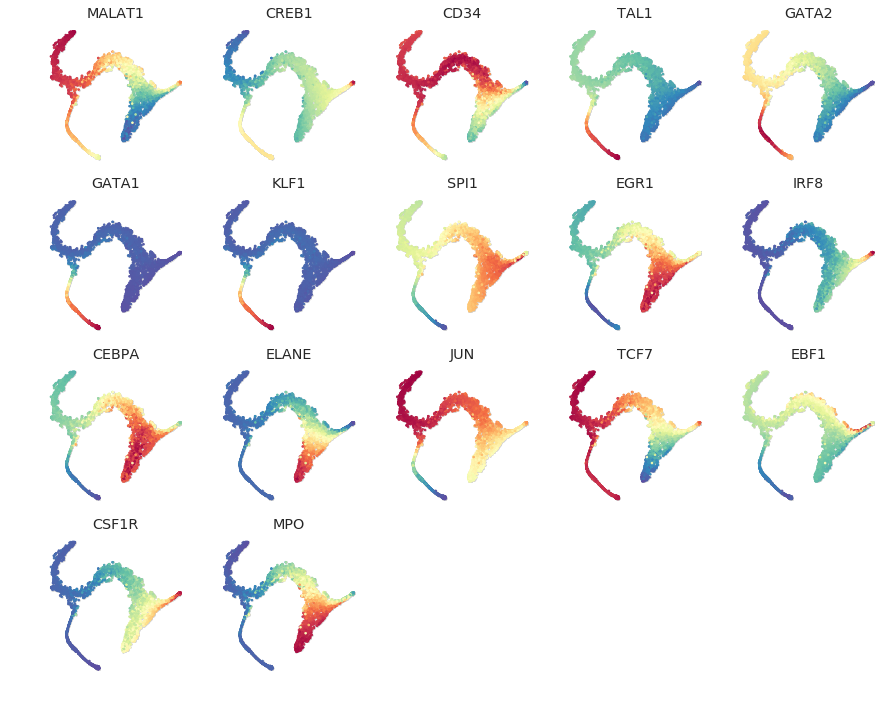

In [95]:
# visualizing imputed gene expression trends across hematopoietic markers of interest
palantir.plot.plot_gene_expression(imp_df, tsne, ['MALAT1', 'CREB1','CD34','TAL1','GATA2','GATA1','KLF1','SPI1','EGR1','IRF8','CEBPA','ELANE','JUN','TCF7','EBF1','CSF1R','MPO'])

saving individual plots with color bars

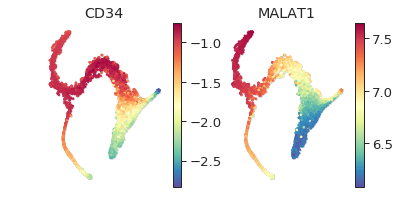

In [99]:
palantir.plot.plot_gene_expression(imp_df, tsne, ['CD34','MALAT1'],plot_scale=True)
fig = plt.gcf()
fig.savefig('./SettyExamplePt_MAGIC-Imputation_KeyGenesOfInterest_CD34+MALAT1_2020-09-14.png', dpi=600)

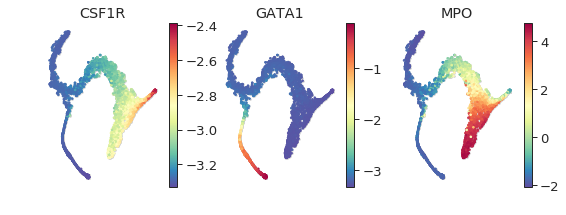

In [100]:
palantir.plot.plot_gene_expression(imp_df, tsne, ['CSF1R','GATA1','MPO'],plot_scale=True)
fig = plt.gcf()
fig.savefig('./SettyExamplePt_MAGIC-Imputation_KeyGenesOfInterest_CSF1R+GATA1+MPO_2020-09-14.png', dpi=600)

In [111]:
import pickle

In [112]:
file_path_out = './SettyExamplePt_prePalantirRes_2020-09-14.pickle'
n_bytes = 2**31
max_bytes = 2**31 -1
data = bytearray(n_bytes)

bytes_out = pickle.dumps([imp_df, tsne, pca_projections, dm_res, ms_data, norm_df], protocol=4)
with open(file_path_out, 'wb') as f_out: 
    for idx in range(0, len(bytes_out), max_bytes):
        f_out.write(bytes_out[idx:idx+max_bytes])

### Running Palantir

In [102]:
# States defined in Setty et al Palantir Tutorial
start_cell = 'Run5_164698952452459'

# terminal states: 1-DC, 2-Mono, 3-Ery
stop_cells = ['Run5_131097901611291', 'Run5_134936662236454', 'Run4_200562869397916']

pr_res = palantir.core.run_palantir(ms_data, start_cell, terminal_states=stop_cells, num_waypoints=500)

Sampling and flocking waypoints...
Time for determining waypoints: 0.0014715313911437989 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.07307459910710652 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9995
Correlation at iteration 2: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [104]:
mapping = pd.Series(index=['DC', 'Mono', 'Ery'])
mapping['DC'] = tsne.loc[pr_res.branch_probs.columns, 'x'].idxmax()
mapping['Ery'] = tsne.loc[pr_res.branch_probs.columns, 'x'].idxmin()
mapping['Mono'] = pr_res.branch_probs.columns.difference(mapping.values)[0]
mapping = pd.Series(mapping.index, index=mapping)

In [105]:
pr_res.branch_probs.columns = mapping[pr_res.branch_probs.columns]

In [106]:
pr_res.branch_probs = pr_res.branch_probs.loc[:, ['Ery', 'Mono', 'DC']]

### Visualizing Palantir Results

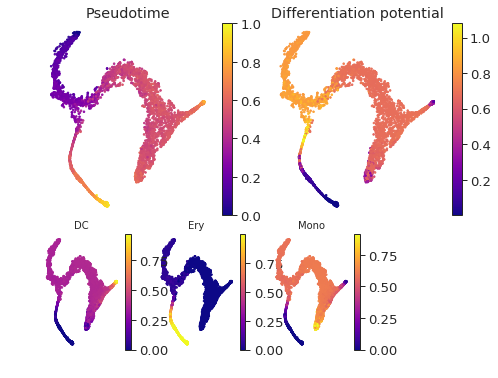

In [108]:
palantir.plot.plot_palantir_results(pr_res, tsne)
fig = plt.gcf()
fig.savefig('./SettyExamplePt_Palantir-Pseudotime-Diff-Pot_2020-09-14.png', dpi=600)

In [114]:
file_path_out = './SettyExamplePt_postPalantirRes_2020-09-14.pickle'
n_bytes = 2**31
max_bytes = 2**31 -1
data = bytearray(n_bytes)

bytes_out = pickle.dumps([start_cell, stop_cells, pr_res, mapping], protocol=4)
with open(file_path_out, 'wb') as f_out: 
    for idx in range(0, len(bytes_out), max_bytes):
        f_out.write(bytes_out[idx:idx+max_bytes])
        